# Build the Conversational Search Building Blocks

<div>
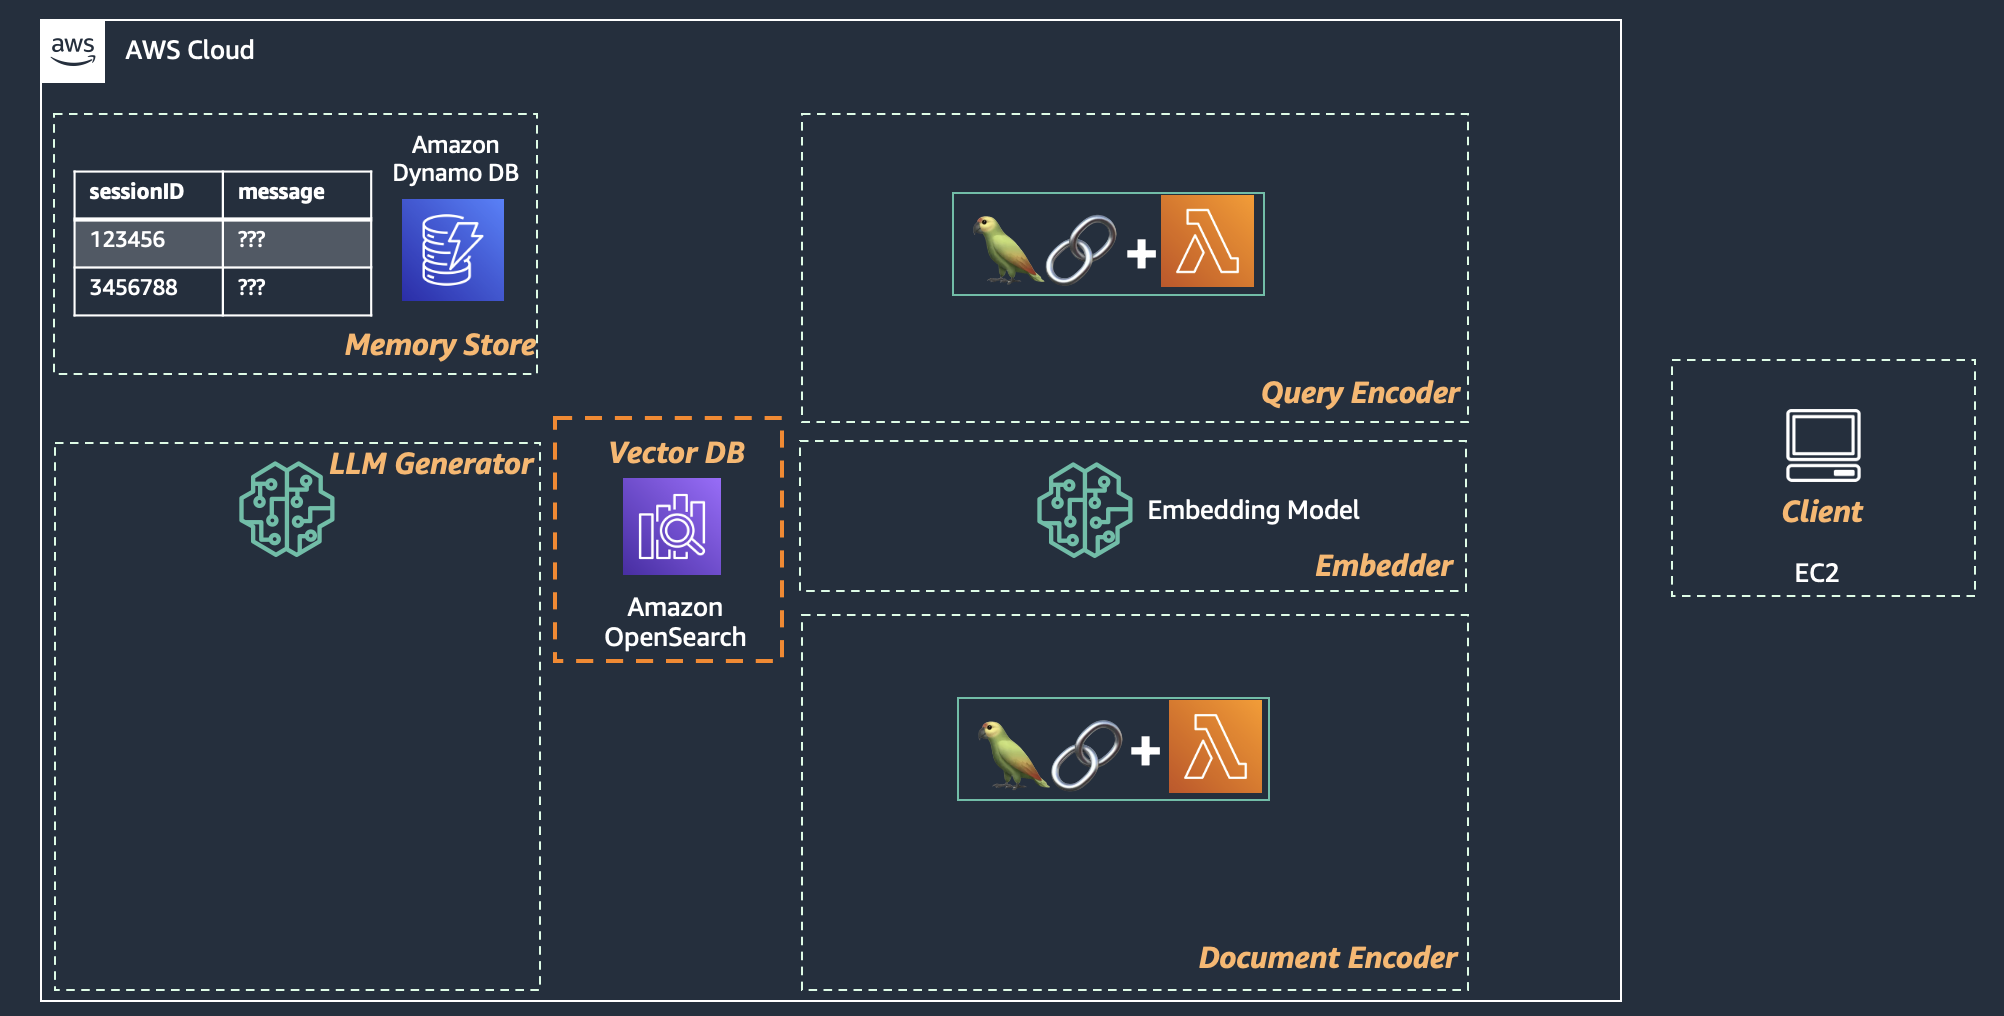
</div>

## Get the Cloudformation outputs

In [3]:
import boto3
import time
import json
cfn = boto3.client('cloudformation')
response = cfn.list_stacks(
   StackStatusFilter=['CREATE_COMPLETE']
)
for cfns in response['StackSummaries']:
    if('semantic-search' in cfns['StackName']):
        stackname = cfns['StackName']
stackname

cfn_outputs = cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']
env_variables = {}
cfn_outputs

[{'OutputKey': 'EmbeddingEndpointName',
  'OutputValue': 'opensearch-gen-ai-embedding-gpt-j-6b-ddafa2a0',
  'Description': 'Name of the LLM endpoint'},
 {'OutputKey': 'S3BucketSecureURL',
  'OutputValue': 'https://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc.s3.amazonaws.com',
  'Description': 'Name of S3 bucket to hold website content'},
 {'OutputKey': 'WebAppURL',
  'OutputValue': 'http://35.173.253.41:8501/',
  'Description': 'web app URL'},
 {'OutputKey': 'SageMakerNotebookURL',
  'OutputValue': 'https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances/openNotebook/semantic-search-nb?view=classic',
  'Description': 'SageMaker Notebook Instance'},
 {'OutputKey': 'OpenSearchDomainName',
  'OutputValue': 'opensearchservi-bzu7bbykwrmu',
  'Description': 'OpenSearch domain name'},
 {'OutputKey': 'OpenSearchSecret',
  'OutputValue': 'arn:aws:secretsmanager:us-east-1:005481197212:secret:OpenSearchSecret-semantic-search-gpu-O5wxOG',
  'Description': 'Name of t

## 1. OpenSearch Vector DB

<div>
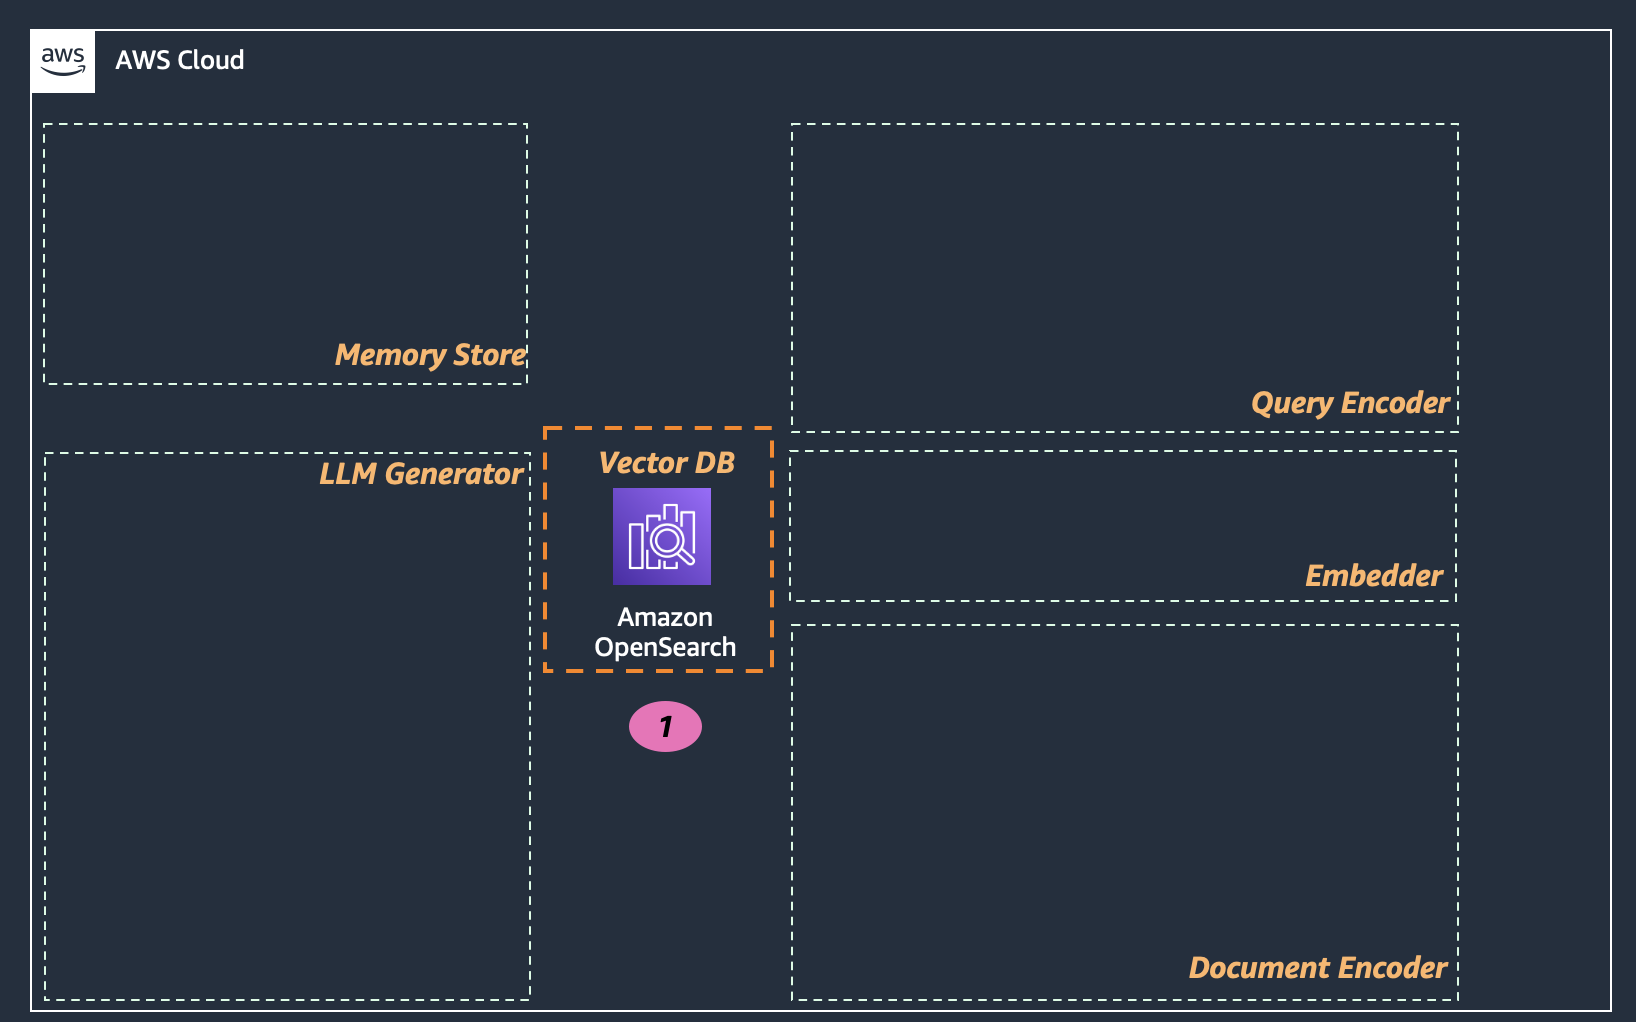
</div>

In [4]:
for output in cfn_outputs:
    if('opensearch' in output['OutputKey'].lower()):
        env_variables[output['OutputKey']] = output['OutputValue']
        
opensearch_ = boto3.client('opensearch')

response = opensearch_.describe_domain(
    DomainName=env_variables['OpenSearchDomainName']
)

print("OpenSearch Version: "+response['DomainStatus']['EngineVersion']+"\n")
print("OpenSearch Configuration\n------------------------\n")
print(json.dumps(response['DomainStatus']['ClusterConfig'], indent=4))        

OpenSearch Version: OpenSearch_2.9

OpenSearch Configuration
------------------------

{
    "InstanceType": "r6g.2xlarge.search",
    "InstanceCount": 1,
    "DedicatedMasterEnabled": false,
    "ZoneAwarenessEnabled": false,
    "WarmEnabled": false,
    "ColdStorageOptions": {
        "Enabled": false
    },
    "MultiAZWithStandbyEnabled": false
}


## 2. Embedding and LLM Endpoints


<div>
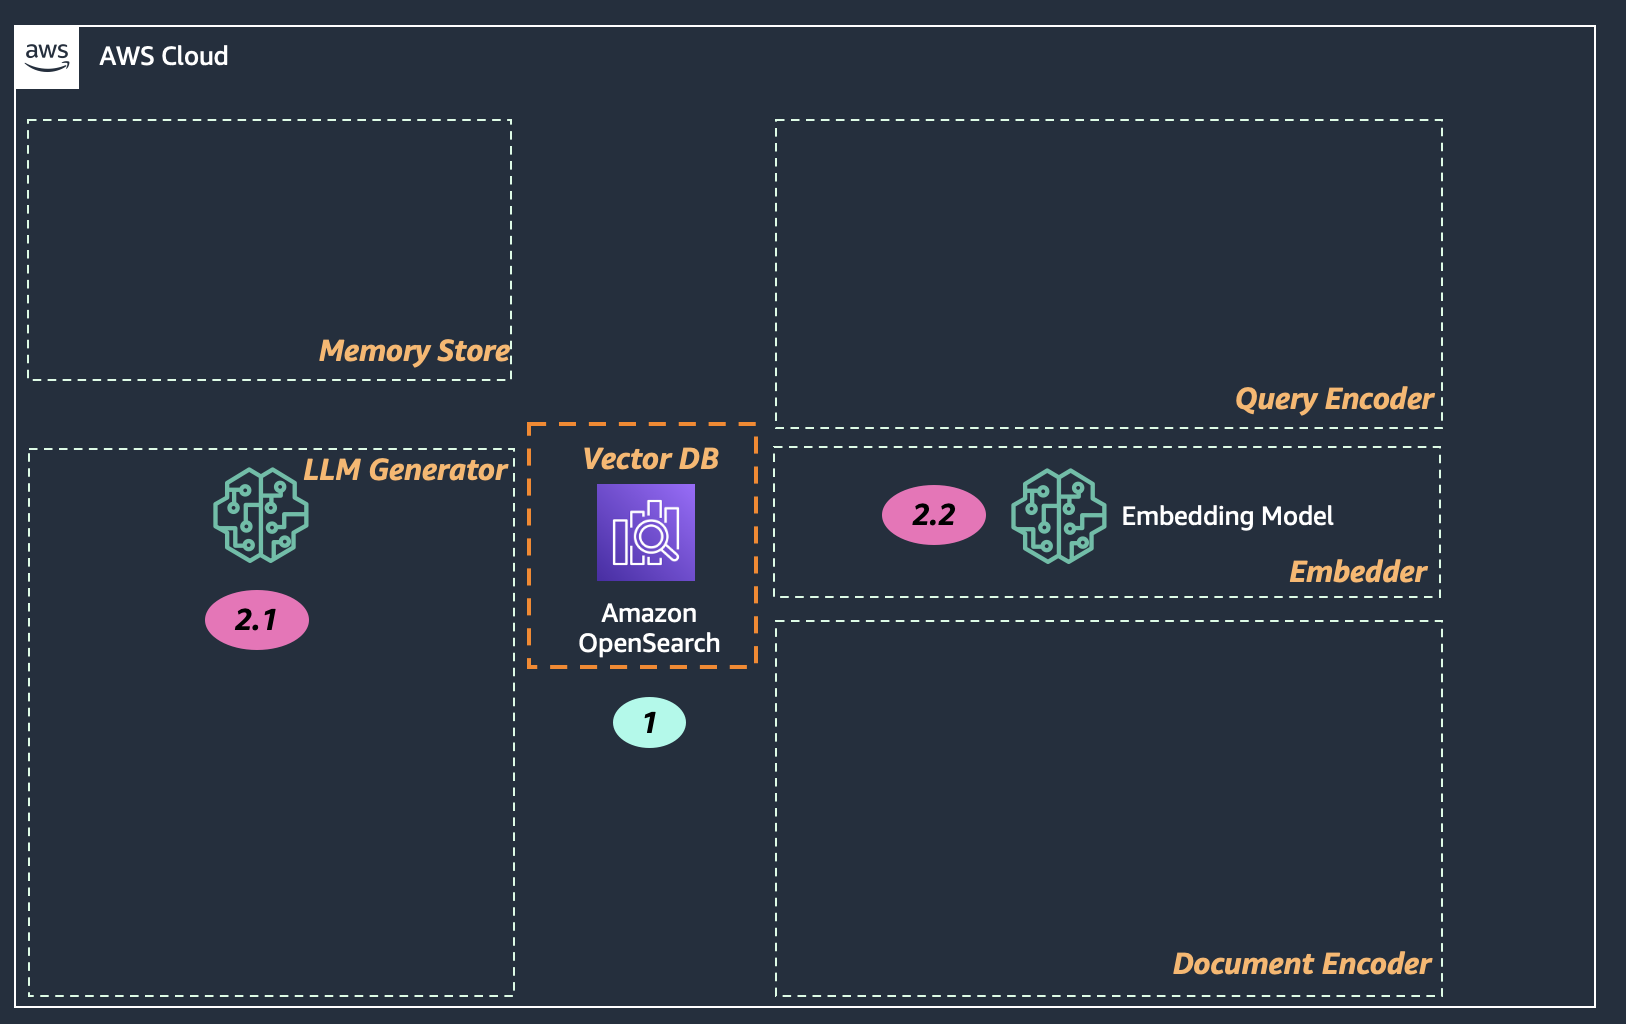
</div>

In [5]:
sagemaker_ = boto3.client('sagemaker')

for output in cfn_outputs:
    if('endpointname' in output['OutputKey'].lower()):
        env_variables[output['OutputKey']] = output['OutputValue']
        print(output['OutputKey'] + " : "+output['OutputValue']+"\n"+"------------------------------------------------")
        print(json.dumps(sagemaker_.describe_endpoint_config(EndpointConfigName = sagemaker_.describe_endpoint(
    EndpointName=output['OutputValue']
                            )['EndpointConfigName'])['ProductionVariants'][0],indent = 4))
        

EmbeddingEndpointName : opensearch-gen-ai-embedding-gpt-j-6b-ddafa2a0
------------------------------------------------
{
    "VariantName": "opensearch-gen-ai-embedding-gpt-j-6b-model-ddafa2a0",
    "ModelName": "opensearch-gen-ai-embedding-gpt-j-6b-model-ddafa2a0",
    "InitialInstanceCount": 1,
    "InstanceType": "ml.g5.2xlarge",
    "InitialVariantWeight": 1.0
}
LLMEndpointName : opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0
------------------------------------------------
{
    "VariantName": "opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0",
    "ModelName": "opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0",
    "InitialInstanceCount": 1,
    "InstanceType": "ml.g5.4xlarge",
    "InitialVariantWeight": 1.0
}


## 3. Memory Store

<div>
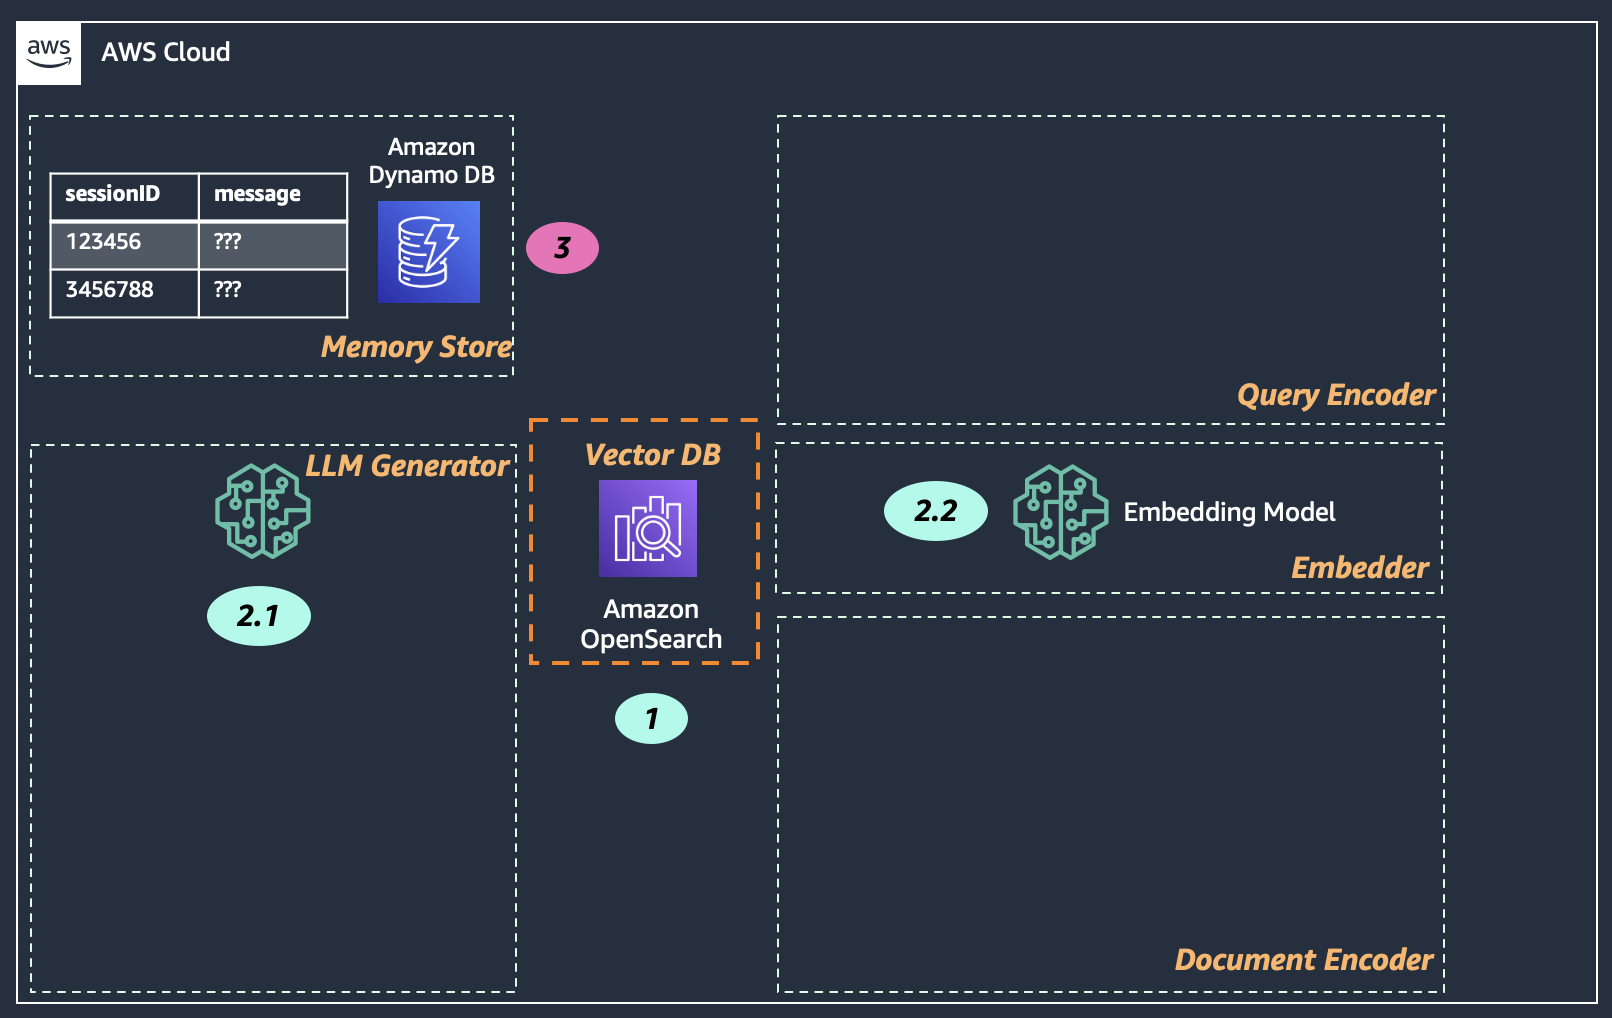
</div>

In [6]:
dynamo = boto3.client('dynamodb')

response = dynamo.create_table(
    TableName='conversation-history-memory',
    AttributeDefinitions=[
        {
            'AttributeName': 'SessionId',
            'AttributeType': 'S',
        }
    ],
    KeySchema=[
        {
            'AttributeName': 'SessionId',
            'KeyType': 'HASH',
        }
    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 5,
        'WriteCapacityUnits': 5,
    }
)
env_variables['DynamoDBTableName'] = response['TableDescription']['TableName']

print("dynamo DB Table, '"+response['TableDescription']['TableName']+"' is created")


dynamo DB Table, 'conversation-history-memory' is created


## 4. Document and Query Encoder

<div>
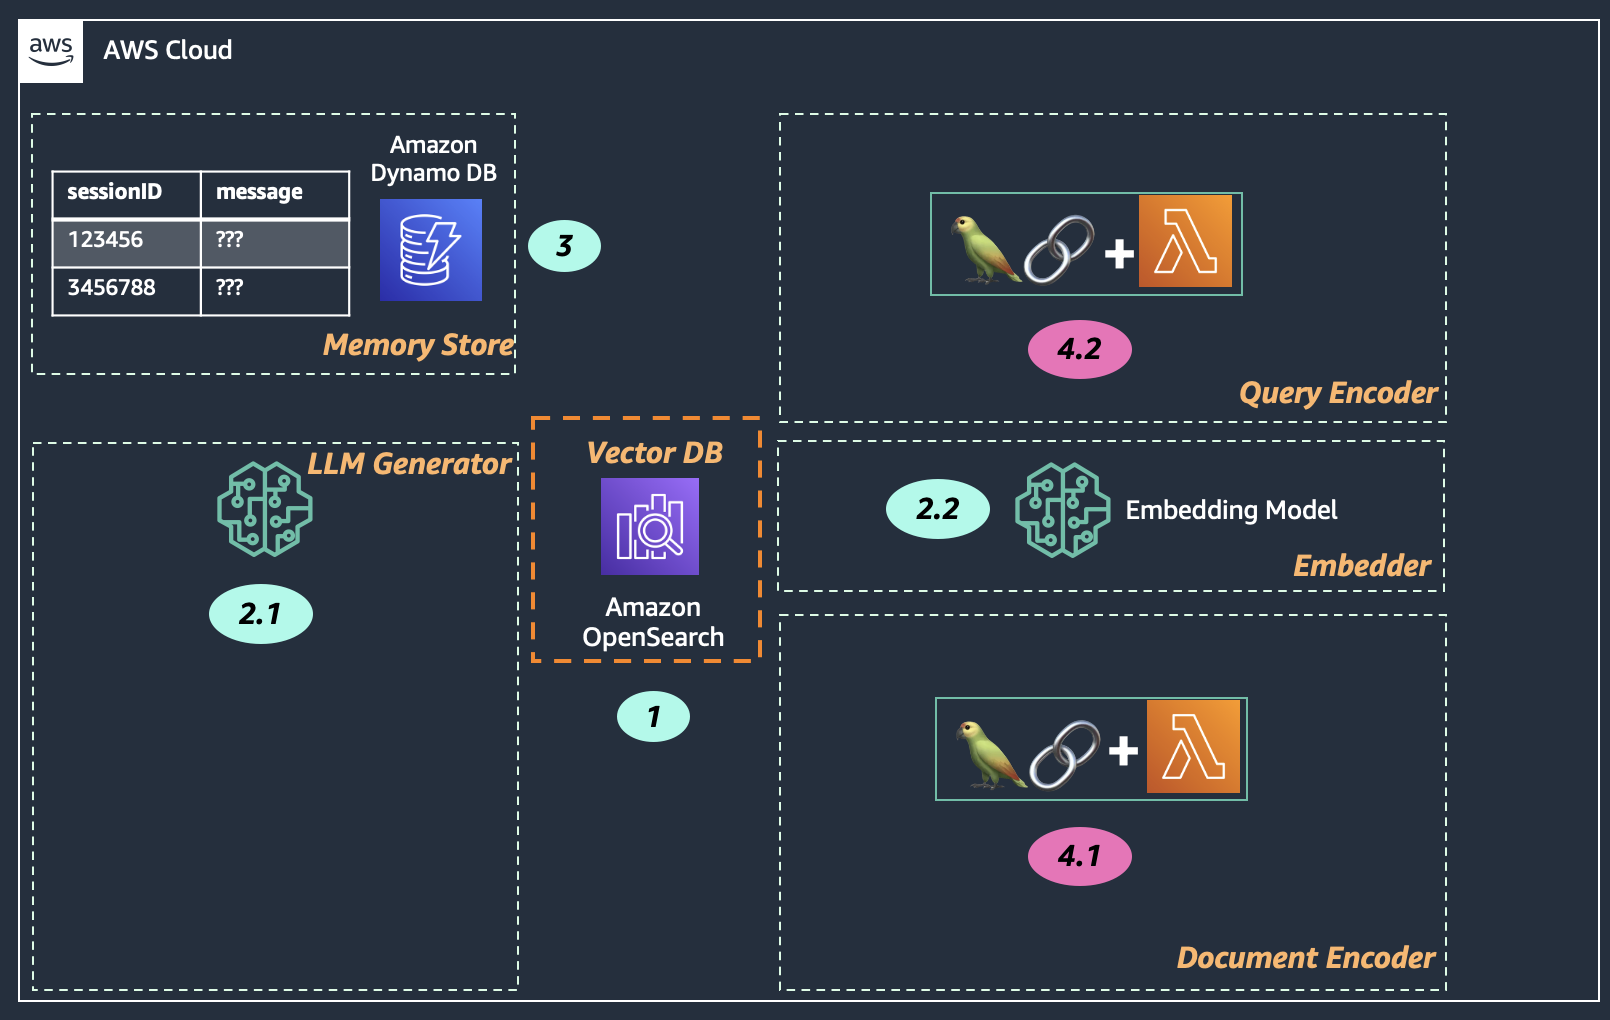
</div>

### 4.1 Package the dependant libraries and handler files for lambda functions

In [8]:
%%capture

# Download the Langchain module
!aws s3 cp s3://ws-assets-prod-iad-r-gru-527b8c19222c1182/2108cfcf-6cd6-4613-83c0-db4e55998757/Langchain.zip .
    
# Create a folder for DocumentEncoder Lambda and unzip the Langchain.zip contents
!mkdir -p documentEncoder
!unzip -o Langchain.zip -d documentEncoder/
!cp -f chain_documentEncoder.py main_documentEncoder.py documentEncoder/
!cd documentEncoder && zip -r documentEncoder.zip *

# Create a folder for QueryEncoder Lambda and unzip the Langchain.zip contents
!mkdir -p queryEncoder
!unzip -o Langchain.zip -d queryEncoder/
!cp -f chain_queryEncoder.py main_queryEncoder.py queryEncoder/
!cd queryEncoder && zip -r queryEncoder.zip *

#Push Lambda artefacts to s3 bucket
for output in cfn_outputs:
    if('s3' in output['OutputKey'].lower()):
        s3_bucket = output['OutputValue']


!aws s3 cp documentEncoder/documentEncoder.zip s3://$s3_bucket
!aws s3 cp queryEncoder/queryEncoder.zip s3://$s3_bucket
    
print("documentEncoder.zip and queryEncoder.zip pushed to "+s3_bucket)

### 4.2 Create the IAM role for Lambda

In [9]:
iam_ = boto3.client('iam')

lambda_iam_role = iam_.create_role(
    RoleName='LambdaRoleforSearch',
    AssumeRolePolicyDocument='{"Version": "2012-10-17", "Statement": [{"Effect": "Allow", "Principal": {"Service": "lambda.amazonaws.com"}, "Action": "sts:AssumeRole"}]}',
    Description='LLMApp Lambda Permissions',
    
)

policies = [
    'AmazonDynamoDBFullAccess',
    'AmazonSagemakerFullAccess',
    'AmazonS3FullAccess',
    'AmazonOpenSearchServiceFullAccess',
    'CloudWatchLogsFullAccess',
    'SecretsManagerReadWrite']

for policy in policies:
    iam_.attach_role_policy(
        RoleName='LambdaRoleforSearch',
        PolicyArn='arn:aws:iam::aws:policy/'+policy
    )
time.sleep(5)    
lambda_iam_role_arn = lambda_iam_role['Role']['Arn']
lambda_iam_role_arn

'arn:aws:iam::005481197212:role/LambdaRoleforSearch'

### 4.3 Deploy lambda functions

In [10]:
lambda_ = boto3.client('lambda')

encoders = ['queryEncoder','documentEncoder']

for encoder in encoders:
    response = lambda_.create_function(
    FunctionName=encoder,
    Runtime='python3.9',
    Role=lambda_iam_role_arn,
    Handler='main_'+encoder+'.handler',
    Code={
        
        'S3Bucket': s3_bucket,
        'S3Key': encoder+'.zip',
        
    },
    Timeout=900,
    MemorySize=512,
    Environment={
        'Variables': env_variables
    }
    )
    print(response['FunctionArn'])
    documentEncoder = response['FunctionArn']

arn:aws:lambda:us-east-1:005481197212:function:queryEncoder
arn:aws:lambda:us-east-1:005481197212:function:documentEncoder


### 4.4 Create external URL for queryEncoder Lambda

In [11]:
response = lambda_.add_permission(
    FunctionName='queryEncoder',
    StatementId='queryEncoder_permissions',
    Action="lambda:InvokeFunctionUrl",
    Principal=documentEncoder.split(':')[4],
    FunctionUrlAuthType='AWS_IAM'
)

response = lambda_.create_function_url_config(
    FunctionName='queryEncoder',
    AuthType='AWS_IAM',
    Cors={
        'AllowCredentials': True,

        'AllowMethods':["*"],
        'AllowOrigins': ["*"]

    },
    InvokeMode='RESPONSE_STREAM'
)

query_invoke_URL = response['FunctionUrl']
query_invoke_URL

'https://6ssuypl2tj3k5v7x4tgh2zlbbm0ukude.lambda-url.us-east-1.on.aws/'

## 5. Host the Chat Application on Ec2

<div>
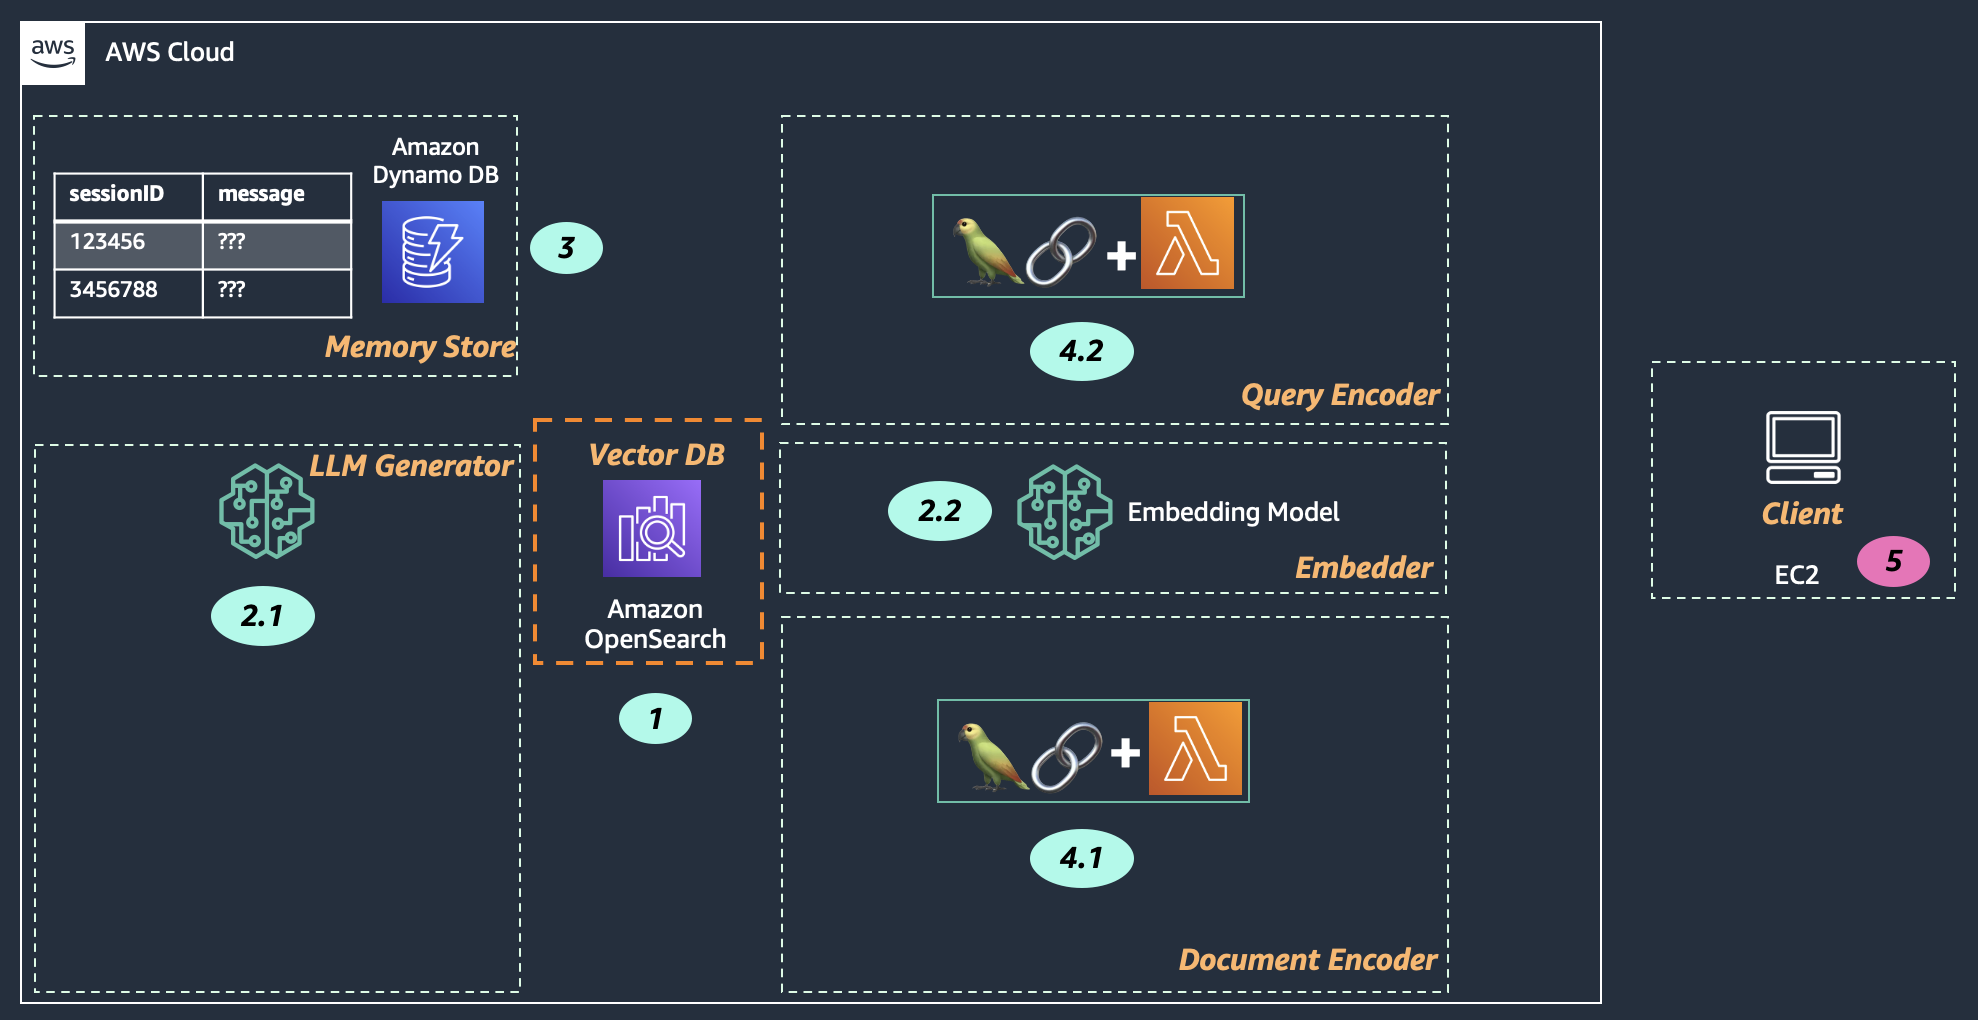
</div>

## 5.1 Copy the webapp code artefacts to ec2

In [19]:
#push the webapp code archive to s3

!cd webapp && zip -r ../webapp.zip *
!aws s3 cp webapp.zip s3://$s3_bucket
    
response = cfn.describe_stack_resources(
    StackName=stackname
)
for resource in response['StackResources']:
    if(resource['ResourceType'] == 'AWS::EC2::Instance'):
        ec2_instance_id = resource['PhysicalResourceId']

query_invoke_URL_cmd = query_invoke_URL.replace("/","\/")#query_invoke_URL
print("\nec2_instance_id: "+ec2_instance_id)

updating: api.py (deflated 56%)
updating: app.py (deflated 65%)
updating: images/ (stored 0%)
updating: pdfs/ (stored 0%)
updating: images/opensearch-twitter-card.png (deflated 5%)
updating: images/user-icon.png (stored 0%)
updating: images/ai-icon.png (stored 0%)
updating: pdfs/OpenSearchFAQ.pdf (deflated 50%)
updating: pdfs/OpenSearch_best_practices.pdf (deflated 64%)
updating: pdfs/sample.pdf (deflated 50%)
upload: ./webapp.zip to s3://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc/webapp.zip

ec2_instance_id: i-07731b4404d849021


## 5.2 Execute ssh comands in ec2 terminal to start the app

In [20]:
# function to execute commands in ec2 terminal
def execute_commands_on_linux_instances(client, commands):
    resp = client.send_command(
        DocumentName="AWS-RunShellScript", # One of AWS' preconfigured documents
        Parameters={'commands': commands},
        InstanceIds=[ec2_instance_id],
    )
    return resp['Command']['CommandId']


ssm_client = boto3.client('ssm') 

query_invoke_URL_cmd = query_invoke_URL.replace("/","\/")

commands = [
            'aws s3 cp s3://'+s3_bucket+'/webapp.zip /home/ec2-user/',
            'unzip -o /home/ec2-user/webapp.zip -d /home/ec2-user/'  ,      
            'sudo chmod -R 0777 /home/ec2-user/',
            'aws s3 cp /home/ec2-user/pdfs s3://'+s3_bucket+'/sample_pdfs/ --recursive',
            'sudo sed -i "s/API_URL_TO_BE_REPLACED/'+query_invoke_URL_cmd+'/g" /home/ec2-user/api.py',
            'sudo sed -i "s/pdf-repo-uploads/'+s3_bucket+'/g" /home/ec2-user/app.py',
            'python3 -m venv /home/ec2-user/.myenv',
            'source /home/ec2-user/.myenv/bin/activate',
            'pip install streamlit',
            'pip install boto3',
    
            #start the web applicaiton
            'streamlit run /home/ec2-user/app.py',
            
            ]

command_id = execute_commands_on_linux_instances(ssm_client, commands)

time.sleep(3)

response = ssm_client.get_command_invocation(
    CommandId=command_id,
    InstanceId=ec2_instance_id
)
print(response['Status'])
print('---------')
print(response['StandardOutputContent']+" The webserver is up and running")


InProgress
---------
 The webserver is up and running


### 5.2 check the ec2 ports which runs the app

In [22]:
#check the status of the applicaiton
commands = [
            "sudo lsof -i -P -n | grep streamlit"
             ]

command_id = execute_commands_on_linux_instances(ssm_client, commands)

time.sleep(3)

response = ssm_client.get_command_invocation(
    CommandId=command_id,
    InstanceId=ec2_instance_id
)
print(response['Status'])
print('---------')
print(response['StandardOutputContent'])
print(response['StandardErrorContent'])


Success
---------
streamlit 2225            root    9u  IPv4  20247      0t0  TCP *:8501 (LISTEN)
streamlit 2225            root   10u  IPv6  20248      0t0  TCP *:8501 (LISTEN)




### 5.3 Open the app using ec2 public DNS

In [23]:
ec2_ = boto3.client('ec2')
response = ec2_.describe_instances(
    InstanceIds=[ec2_instance_id]
)
public_ip = response['Reservations'][0]['Instances'][0]['PublicIpAddress']
print('http://'+public_ip+":8501")

http://52.200.167.77:8501
